# UMAP
## A Functional Introduction

### Uniform Manifold Approximation and Projection (UMAP) 
is a dimension reduction
technique that can be used for visualisation similarly to t-SNE, but also for
general non-linear dimension reduction. The algorithm is founded on three
assumptions about the data

1. The data is uniformly distributed on Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected (not globally, but locally).

From these assumptions it is possible to model the manifold with a fuzzy
topological structure. The embedding is found by searching for a low dimensional
projection of the data that has the closest possible equivalent fuzzy
topological structure.




### A Simple Task
Lets just run umap on a common dataset, using the UMAP defaults

In [2]:
# Grab what we need via imports
from sklearn.datasets import load_digits
import numpy as np

# DR methods
#import umap
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA, KernelPCA

# Visualizations
import matplotlib.pyplot as plt
%matplotlib nbagg
# Bokeh imports
import bokeh.plotting as bk
bk.output_notebook()
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()


# Load in the digit dataset, and take a look at its shape
digits = load_digits()
labels = digits.target



Loading BokehJS ...

Loading BokehJS ...

### UMAP it!

In [22]:
# This is the embedding
%time embedding = umap.UMAP(n_components=2).fit_transform(digits.data)

CPU times: user 2.03 s, sys: 604 ms, total: 2.63 s
Wall time: 1.88 s


In [23]:
# Here lets compare the original shape to the embedding
print("Original Data Shape: ", digits.data.shape)
print("Embedded Data Shape: ", embedding.shape)

('Original Data Shape: ', (1797, 64))
('Embedded Data Shape: ', (1797, 2))


That's all well and good, but I want to see what the embedding looks like. 
Let's make a simple plot

<IPython.core.display.Javascript object>


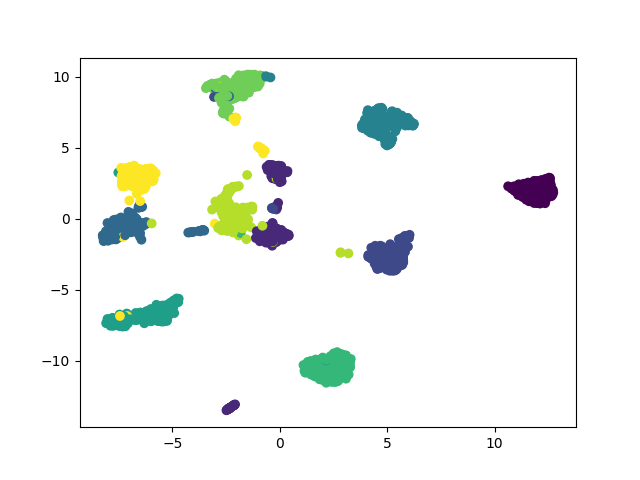

In [129]:
plt.scatter(embedding[:,0], embedding[:,1], c=digits.target)
plt.show()

This is colored according to the target number, and then mapped to rbg by matplotlib. This is also all well and good, but I want to be able to interrogate the plot a bit more thoroughly. For this I'm going to use bokeh. 
In the next plot, you'll be able to zoom in and out, and mouse over the scatter plot points. There'll be a hover window that appears and shows you the number source, and shows you the target number next to the image (on the left and right hand side of the hovertool respectively)

First I need to create the images from digits.data, then save them so bokeh can load the image

In [3]:
# Right there's almost certainly a better way to do this, but I can't think of it, 
#  So I'm going to bodge it

# This block of code builds a png image for each number.  for 
from PIL import Image
import PIL
#im = Image.fromarray(A)

# BODGE
import os
imgSource = []




if not os.path.isfile('imgs/0.png'):
    for i in range(len(digits.data)):
        x = digits.data[i].reshape((8, 8))
        #myA = (x-np.amin(x))/(np.amax(x)-np.amin(x))
        #im = Image.fromarray(np.uint8(myA))
        #size = 150,150
        im = Image.new('L', (len(x[0]), len(x)))  # type, size
        im.putdata([int(255-p*255) for row in x for p in row])
        #im = im.resize(size, PIL.Image.ANTIALIAS)
        #print x
        #im.show()
        #break
        im.save("imgs/"+str(i)+".png")
        #imgSource.append( "http://localhost:8888/notebooks/Documents/filesForProgramming/dim_Reduction/umap/notebook/imgs/"+str(i)+".png")
        imgSource.append( "imgs/"+str(i)+".png")
    
else:
    for i in range(len(digits.data)):
        imgSource.append( "imgs/"+str(i)+".png")
    

Now that the ugly bodge is dealt with, we can focus on the plotting

This block of code will take in the lower d points, take in a set of labels, a list of files to the source images, and an optional title. It returns a bokeh figure which can be displayed elsewhere in code.

Hovering over any point in the plot will show the hovertool, which should display the digit image on the left, and the number it's classifed as on the right

In [4]:




def makePlot(embedding, labels, imgs, title=''):
    def mapNumToC(c):

        mini = float(min(c))
        maxi = float(max(c))
        print mini, maxi
        colors = []
        for i in c:
            i = float(i)
            ratio = 2. * (i - mini) / (maxi-mini)
            b = int(max(0, 255*(1 - ratio)))
            r = int(max(0, 255*(ratio - 1)))
            g = 255 - b - r
            colors.append('#%02x%02x%02x' % (r,g,b))
        return colors

    c = mapNumToC(labels)

    source = ColumnDataSource(data=dict(
        x=embedding[:,0],
        y=embedding[:,1],
        value=labels,
        fill_color=c,
        imgs=imgs
    ))

    #hover = HoverTool(tooltips=[
    #    ("Number", "@value")
    #])
    #'''
    # Todo: figure out how to display the number in the bokeh plot
    hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="16" alt="@imgs" width="16"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
                
                <span style="float: right;font-size: 16px; font-weight: bold;">@value</span>
            </div>
        </div>
        """
    )
    #'''
    p = figure(tools=[hover, 'reset,wheel_zoom,undo,redo,save,tap,pan'],
               title=title)

    p.circle('x', 'y', size=8, source=source, line_color=None, fill_color=c)
    
    return p



In [5]:

p = makePlot(embedding, labels, imgSource)
t = show(p)

NameError: name 'embedding' is not defined

### Take some time to explore this plot
Without looking at the specific points, you can see that UMAP does a really good job for the most part. And mousing over the points that look like they're in the wrong cluster, you can see that those numbers actually look like their neighbors. But lets get a bit of persepective 

For that, we're going to compare UMAP with the classic PCA (by way of singular value decomposition) and to the currently very popular t-SNE.

### First taking a look at PCA 
Being a linear method, it's very fast

However if the data is the result of some non linear function, it fails to useful capture the information in just two dimensions.  

In [6]:
%time pca_Embedding = PCA(n_components=2).fit_transform(digits.data)

Wall time: 719 ms


In [7]:
pca_p = makePlot(pca_Embedding, labels, imgSource)
pca_t = show(pca_p)

0.0 9.0


C:\Users\kmurr\Anaconda2\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


### Next we'll examine t-SNE
It's currently being used becuase it's very fast for a non linear dimensionaly reduction algorithm, and it scales much better than what was previously the state of the art when data increases in amount, and dimensionality. This is in part thanks to the barnes-hut approximation


In [11]:
%time tsne_Embedding = manifold.TSNE(n_components=2).fit_transform(digits.data)

Wall time: 1min 18s


In [12]:
tsne_p = makePlot(tsne_Embedding, labels, imgSource)
tsne_t = show(tsne_p)

0.0 9.0


C:\Users\kmurr\Anaconda2\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


### Comparing the plots
We can see that singular value decomposition is not particularly useful in the data visualization. The first two principle componets don't have enough information to show the sepperation between numbers that you see with UMAP and t-SNE
UMAP and t-SNE reduce the dimensions while preserving the distance between distince clusters of numbers. Looking at both t-SNE and UMAP, we can see there are some points which have been mapped near different numbers. 

Mousing over we can see why, 'digits' isn't the cleanest data, and the numbers honestly look similar to the numbers they're clustered around. Some people just have bad handwritting. 

## Getting more control


In [21]:

from bokeh.layouts import gridplot
grid = gridplot([[makePlot(tsne_Embedding, labels, imgSource), None], [None, makePlot(pca_Embedding, labels, imgSource)]])

# show the results
show(grid)

0.0 9.0
0.0 9.0


C:\Users\kmurr\Anaconda2\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\kmurr\Anaconda2\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


In [20]:
show(tsne_p)